## Tasks: 

- Process data(loading, imputting, dropping, scaling) with `pyspark`
- Linear Regression on the Boston Housing dataset with `pyspark`
- Add regularization and grid-search for hyper-parameters with `pyspark`
- Model evaluation with `pyspark`
  
PySpark API Documentation: https://spark.apache.org/docs/latest/api/python/index.html

Spark DataFrame Guide:  https://spark.apache.org/docs/latest/sql-programming-guide.html

Spark MLlib Guide: https://spark.apache.org/docs/latest/ml-guide.html

### Import libraries/functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline
plt.style.use('seaborn-whitegrid')

### Initialize Spark
* Initialize Spark with 2 cores

In [2]:
conf = pyspark.SparkConf().setAll([('spark.master','local[2]'), ('spark.app.name','PA3')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

### Read the data from Boston_Housing.csv file
* Print the number of rows in the dataframe

In [3]:
housing = spark.read.csv('file:/home/work/PA3/Boston_Housing.csv', header=True)
print(housing.count())

506


### Column names in file and their description

CRIM — per capita crime rate by town.

ZN — proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS — proportion of non-retail business acres per town.

CHAS — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

NOX — nitrogen oxides concentration (parts per 10 million).

RM — average number of rooms per dwelling.

AGE — proportion of owner-occupied units built prior to 1940.

DIS — weighted mean of distances to five Boston employment centres.

RAD — index of accessibility to radial highways.

TAX — full-value property-tax rate per $10,000.

PTRATIO — pupil-teacher ratio by town.

BLACK — 1000(Bk — 0.63)² where Bk is the proportion of blacks by town.

LSTAT — lower status of the population (percent).

MV — median value of owner-occupied homes in $1000s. This is the target variable.

### See one row of the dataframe

In [4]:
print(housing.show(1))

+-------+----+-----+----+-----+-----+----+----+---+-----+-------+-----+-----+----+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE| DIS|RAD|  TAX|PTRATIO|BLACK|LSTAT|  MV|
+-------+----+-----+----+-----+-----+----+----+---+-----+-------+-----+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|4.09|  1|296.0|   15.3|396.9| 4.98|24.0|
+-------+----+-----+----+-----+-----+----+----+---+-----+-------+-----+-----+----+
only showing top 1 row

None


### Helper function for filling columns using mean or median strategy

In [5]:
from pyspark.ml.feature import Imputer

def fill_na(df, strategy):    
    imputer = Imputer(
        strategy=strategy,
        inputCols=df.columns, 
        outputCols=["{}_imputed".format(c) for c in df.columns]
    )
    
    new_df = imputer.fit(df).transform(df)
    
    # Select the newly created columns with all filled values
    new_df = new_df.select([c for c in new_df.columns if "imputed" in c])
    
    for col in new_df.columns:
        new_df = new_df.withColumnRenamed(col, col.split("_imputed")[0])
        
    return new_df

### Feature selection
* Print schema to verify

In [6]:
# These are the column names in the csv file as described above.
col_names = ['CRIM' , 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'BLACK', 'LSTAT', 'MV']

print(housing.printSchema())

root
 |-- CRIM: string (nullable = true)
 |-- ZN: string (nullable = true)
 |-- INDUS: string (nullable = true)
 |-- CHAS: string (nullable = true)
 |-- NOX: string (nullable = true)
 |-- RM: string (nullable = true)
 |-- AGE: string (nullable = true)
 |-- DIS: string (nullable = true)
 |-- RAD: string (nullable = true)
 |-- TAX: string (nullable = true)
 |-- PTRATIO: string (nullable = true)
 |-- BLACK: string (nullable = true)
 |-- LSTAT: string (nullable = true)
 |-- MV: string (nullable = true)

None


### Drop NA's in the target variable `MV`
* Print the number of remaining rows

In [7]:
housing.filter(housing['MV'].isNotNull())
print(housing.count())

506


### Fill the NA's for remaining columns using a mean strategy
* Use the `fill_na` function provided above

In [8]:
# cast all columns to 'float' type
housing = housing.select(*(col(c).cast("float").alias(c) for c in housing.columns))
print(housing.printSchema())

housing = fill_na(housing, 'mean')

root
 |-- CRIM: float (nullable = true)
 |-- ZN: float (nullable = true)
 |-- INDUS: float (nullable = true)
 |-- CHAS: float (nullable = true)
 |-- NOX: float (nullable = true)
 |-- RM: float (nullable = true)
 |-- AGE: float (nullable = true)
 |-- DIS: float (nullable = true)
 |-- RAD: float (nullable = true)
 |-- TAX: float (nullable = true)
 |-- PTRATIO: float (nullable = true)
 |-- BLACK: float (nullable = true)
 |-- LSTAT: float (nullable = true)
 |-- MV: float (nullable = true)

None


### Create feature vector using VectorAssembler

* Create a vector column composed of _all_ the features
* Don't include the label "MV" here since label isn't a feature

In [9]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['CRIM' , 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'BLACK', 'LSTAT'],
    outputCol="features")

housing = assembler.transform(housing)

### Print first 5 rows of the created dataframe

In [10]:
housing.show(5)

+-----+-----+----+----+-------+-------+------+---+-----+----+-----+----+------+-----+--------------------+
|INDUS|  NOX| AGE|CHAS|PTRATIO|   CRIM|   DIS|RAD|   RM|  ZN|  TAX|  MV| BLACK|LSTAT|            features|
+-----+-----+----+----+-------+-------+------+---+-----+----+-----+----+------+-----+--------------------+
| 2.31|0.538|65.2| 0.0|   15.3|0.00632|  4.09|1.0|6.575|18.0|296.0|24.0| 396.9| 4.98|[0.00632000016048...|
| 7.07|0.469|78.9| 0.0|   17.8|0.02731|4.9671|2.0|6.421| 0.0|242.0|21.6| 396.9| 9.14|[0.02731000073254...|
| 7.07|0.469|61.1| 0.0|   17.8|0.02729|4.9671|2.0|7.185| 0.0|242.0|34.7|392.83| 4.03|[0.02728999964892...|
| 2.18|0.458|45.8| 0.0|   18.7|0.03237|6.0622|3.0|6.998| 0.0|222.0|33.4|394.63| 2.94|[0.03237000107765...|
| 2.18|0.458|54.2| 0.0|   18.7|0.06905|6.0622|3.0|7.147| 0.0|222.0|36.2| 396.9| 5.33|[0.06904999911785...|
+-----+-----+----+----+-------+-------+------+---+-----+----+-----+----+------+-----+--------------------+
only showing top 5 rows



### Rename the column `MV` to `Label`

In [11]:
housing = housing.withColumn('Label', col('MV'))
housing = housing.select('features', 'Label')
housing.show()

+--------------------+-----+
|            features|Label|
+--------------------+-----+
|[0.00632000016048...| 24.0|
|[0.02731000073254...| 21.6|
|[0.02728999964892...| 34.7|
|[0.03237000107765...| 33.4|
|[0.06904999911785...| 36.2|
|[0.02985000051558...| 28.7|
|[0.08828999847173...| 22.9|
|[0.14454999566078...| 27.1|
|[0.21123999357223...| 16.5|
|[0.17003999650478...| 18.9|
|[0.22488999366760...| 15.0|
|[0.11747000366449...| 18.9|
|[0.09378000348806...| 21.7|
|[0.62976002693176...| 20.4|
|[0.63796001672744...| 18.2|
|[0.62739002704620...| 19.9|
|[1.05393004417419...| 23.1|
|[0.78420001268386...| 17.5|
|[0.80270999670028...| 20.2|
|[0.72579997777938...| 18.2|
+--------------------+-----+
only showing top 20 rows



### Split the dataframe using the randomSplit() function 
 * Train dataframe and test dataframe with a 75:25 split between them
 * Use seed=42 as one the parameters of the randomSplit() function to maintain consistency among all submissions.
 * Print the number of rows in train and test dataframes

In [47]:
train_df, test_df = housing.randomSplit([0.71, 0.3], 42)
print(train_df.count())
print(test_df.count())

379
127


### Use the StandardScaler to standardize your data.
* **IMPORTANT** - Use only the training data for scaling
* Standardize values to have zero mean and unit standard deviation

In [44]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

scalerModel = scaler.fit(train_df)

### Scale your training and test data with the same mean and std that you'll get from the scaler.

In [45]:
train_df = scalerModel.transform(train_df)
test_df = scalerModel.transform(test_df)

In [15]:
train_df.show()

+--------------------+-----+--------------------+
|            features|Label|      scaledFeatures|
+--------------------+-----+--------------------+
|[0.00632000016048...| 24.0|[8.03394380808371...|
|[0.00906000006943...| 32.2|[0.00115170141789...|
|[0.01300999987870...| 32.7|[0.00165382286890...|
|[0.01310999970883...| 35.4|[0.00166653478338...|
|[0.01360000018030...| 18.9|[0.00172882333012...|
|[0.01432000007480...| 31.6|[0.00182034925650...|
|[0.01501000020653...| 50.0|[0.00190806163222...|
|[0.01537999976426...| 44.0|[0.00195509573950...|
|[0.01709000021219...| 30.1|[0.00217246990345...|
|[0.01964999921619...| 20.1|[0.00249789534055...|
|[0.02009000070393...| 50.0|[0.00255382804843...|
|[0.02054999954998...| 24.7|[0.00261230280772...|
|[0.02187000028789...| 31.1|[0.00278010045781...|
|[0.02542999945580...| 23.9|[0.00323264527657...|
|[0.02762999944388...| 30.8|[0.00351230786887...|
|[0.02875000052154...| 25.0|[0.00365468168998...|
|[0.02899000048637...| 26.6|[0.00368519033211...|


### Use `scaler_model.mean`, `scaler_model.std` to see the mean and std for each feature

In [16]:
print(scalerModel.mean)
print()
print(scalerModel.std)

[3.4071267437187367,10.527704485488123,11.236332547696103,0.07387862796833773,0.5571812670432168,6.287635883743976,69.10237468201126,3.7759606948314084,9.482849604221633,408.9868073878625,18.425857747764887,358.52730664807467,12.805857513384955]

[7.866622310858527,22.123956891256963,6.8662067922898915,0.26191903923437193,0.11770544540574955,0.7042372508923194,28.009596375346856,2.1206513409734726,8.631589350485603,168.2070950038125,2.2263257825784453,87.08070362968968,7.087330066497796]


### Select only the `features` and `label` columns from both train and test dataset

In [17]:
train_df = train_df.select('scaledFeatures', 'Label')
test_df = test_df.select('scaledFeatures', 'Label')

### Show the first 5 rows of the resulting train dataframe

In [18]:
print(train_df.show(5))

+--------------------+-----+
|      scaledFeatures|Label|
+--------------------+-----+
|[8.03394380808371...| 24.0|
|[0.00115170141789...| 32.2|
|[0.00165382286890...| 32.7|
|[0.00166653478338...| 35.4|
|[0.00172882333012...| 18.9|
+--------------------+-----+
only showing top 5 rows

None


### Use LinearRegression for training a regression model.
* Use maxIter = 100.
* Use the following values for regParam and elasticNetParam and see which one works better.
  1. regParam = 0, elasticNetParam = 0
  2. regParam = 0.3, elasticNetParam = 0.5

Look into the [API](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.regression.LinearRegression.html) specification to get more details.

In [19]:
lr1 = LinearRegression(featuresCol='scaledFeatures', labelCol='Label', maxIter=100, regParam=0.0, elasticNetParam = 0, solver="normal")
lr2 = LinearRegression(featuresCol='scaledFeatures', labelCol='Label', maxIter=100, regParam=0.3, elasticNetParam = 0.5, solver="normal")

lr1_model = lr1.fit(train_df)
lr2_model = lr2.fit(train_df)

### Print the coefficients and intercept of the linear regression model

In [20]:
print("Coefficients: " + str(lr1_model.coefficients))
print("Intercept: " + str(lr1_model.intercept))

print("Coefficients: " + str(lr2_model.coefficients))
print("Intercept: " + str(lr2_model.intercept))

Coefficients: [-0.9418276837760206,1.0448586549741308,0.3087173078075704,0.7672786116564864,-1.9519530119216189,3.1248584035958027,-0.17678322791310788,-2.9062457990654025,2.38701850982334,-2.526246884999499,-1.9255040972342408,0.6782048519087396,-2.9699887200828003]
Intercept: 30.584247544171312
Coefficients: [-0.4341791994813718,0.4701882954426564,-0.09709921821747299,0.7618666142311472,-1.1141570335868045,3.348247965016999,0.0,-1.6408001890498238,0.17770116958058188,-0.6658955407063449,-1.7263026277864595,0.5092971184782086,-2.8999280188301553]
Intercept: 19.47779097132082


### Print the training results
* Print the root mean squared error(RMSE) of the training
* Print the coefficient of determination(r2) of the training

In [37]:
lr1_Summary = lr1_model.summary
print(f"RMSE: {lr1_Summary.rootMeanSquaredError}")
print(f"r2: {lr1_Summary.r2}")

lr2_Summary = lr2_model.summary
print(f"RMSE: {lr2_Summary.rootMeanSquaredError}")
print(f"r2: {lr2_Summary.r2}")

RMSE: 4.290887846987993
r2: 0.7700074195355654
RMSE: 4.42450433381903
r2: 0.7554606525390561


### Test the model on test data
* Print the RMSE and r2 on test data
* Hint - Refer to [`RegressionEvaluator`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html)

In [38]:
lr1_pred = lr1_model.transform(test_df)
lr1_eval = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Label",metricName="r2")
lr1_result = lr1_model.evaluate(test_df)

print(f"RMSE(regParam = 0, elasticNetParam = 0): {lr1_result.rootMeanSquaredError}")
print(f"r2(regParam = 0, elasticNetParam = 0): {lr1_eval.evaluate(lr1_pred)}")

RMSE(regParam = 0, elasticNetParam = 0): 5.826628715990164
r2(regParam = 0, elasticNetParam = 0): 0.6510124031338022


### Plot results on test data(using matplotlib)

 * In the test data, you have labels, and you also have predictions for each of the test data.
 * Plot a scatter plot of the labels(in blue) and predictions(in red) on a single plot so that you can visualize how the predictions look as compared to the ground truth.


In [24]:
lr1_ = lr1_pred.select('prediction').toPandas()

y_test = test_df.select('Label').toPandas()

In [25]:
x = np.arange(y_test.shape[0])

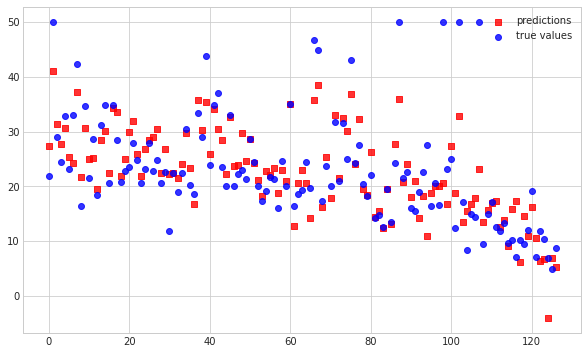

In [39]:
plt.figure(figsize=(10,6))
x = np.arange(y_test.shape[0])
plt.scatter(x, lr1_, alpha=0.8, marker='s', c='r', label='predictions')
plt.scatter(x, y_test, alpha=0.8, marker='o', c='b', label='true values')
plt.legend();

### Add regularization to model
* Try different values of regularization parameters `regParam` and `elasticNetParam` to see how performance changes.
* Look into the API specification for [regParam](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html#pyspark.ml.regression.LinearRegression.regParam) and [elasticNetParam](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html#pyspark.ml.regression.LinearRegression.elasticNetParam) to get more details.

I will be running a pipeline with standard scaler and cross-validation to search for the best `regParam` and `elasticNetParam`.

In [48]:
train_df, test_df = housing.randomSplit([0.71, 0.3], 42)

# set each stage for pipeline
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
lr = LinearRegression(maxIter=100, featuresCol='scaledFeatures', labelCol='Label')

# create pipeline
pipeline = Pipeline(stages=[scaler, lr])

# create paramter grid
paramGrid = ParamGridBuilder()\
               .addGrid(lr.regParam, [0.001, 0.01, 0.1, 0.5, 1.0, 2.0])\
               .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])\
               .build()

# set evaluator
lrevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Label", metricName="rmse")
 
# create cross-validator
crossval = CrossValidator(estimator=pipeline, \
                          estimatorParamMaps=paramGrid, \
                          evaluator=lrevaluator, \
                          numFolds=5) 
 
# run cross-validator    
cvModel = crossval.fit(train_df)
prediction = cvModel.transform(test_df)

In [49]:
# get cross-validator model summary
cvModelSummary = cvModel.bestModel.stages[-1].summary
#print("Coefficient Standard Errors: " + str(cvModelSummary.coefficientStandardErrors))
#print("P Values: " + str(cvModelSummary.pValues)) # Last element is the intercept

In [50]:
print("Best RegParam = ", cvModel.bestModel.stages[-1].getRegParam())

Best RegParam =  0.1


In [51]:
print("Best elasticNetParam = ", cvModel.bestModel.stages[-1].getElasticNetParam())

Best elasticNetParam =  0.0


In [52]:
# measure the accuracy of our model on test data
cv_pred = cvModel.transform(test_df)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('Test RMSE:', lrevaluator.evaluate(cv_pred))

Test RMSE: 5.84125653321618


### Stop the spark session

In [53]:
spark.stop()